<a href="https://colab.research.google.com/github/davidalvarez03/Polynomials/blob/main/PolynomialDavid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# some python imports
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize
import tensorflow_probability as tfp
from scipy.stats import norm
tfd = tfp.distributions

In [ ]:
# The true parameters
TRUE_W = 5.0
TRUE_B = 1.0
NUM_DATA = 201

# A vector of random x values
x = tf.linspace(-2,2, NUM_DATA)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

mean=0
std=3
# Generate some noise
noise = tf.random.normal(shape=[NUM_DATA], mean=mean, stddev=std)

# Calculate y
y = f(x) + noise
y=tf.cast(y, tf.float32)

# Plot all the data
plt.plot(x, y, '.')
plt.show()

In [4]:
class MyModel(tf.Module):
  def __init__(self,w_initial,b_initial):
    super().__init__()
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(w_initial, name='w')
    self.b = tf.Variable(b_initial)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel(5.0,0.0)

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'w:0' shape=() dtype=float32, numpy=5.0>)


In [5]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

#defining the prior
#DEFINING THE PRIOR, LIKELIHOOD AND POSTERIOR

def logprior(model):
    lin_coef, ind_coef = model.w.numpy(),model.b.numpy()
    p_lin_coef=tfd.Uniform(-5,5)
    p_ind_coef=tfd.Uniform(-5,5)
    return p_ind_coef.log_prob(lin_coef)+p_ind_coef.log_prob(ind_coef)

def loglikelihood(model,x,target_y):
    lin_coef, ind_coef = model.w.numpy(),model.b.numpy()
    predicted_y=model(x)
    a = 0
    sigma=1
    for i in range(len(target_y)):
      prob_y=tfd.Normal(target_y[i],sigma)
      a=a+prob_y.log_prob(predicted_y[i])
    return a

def logposterior(model,x,target_y):
  return logprior(model)+loglikelihood(model,x,target_y)

def loss(model,x,target_y):
  return -logposterior(model,x,target_y)

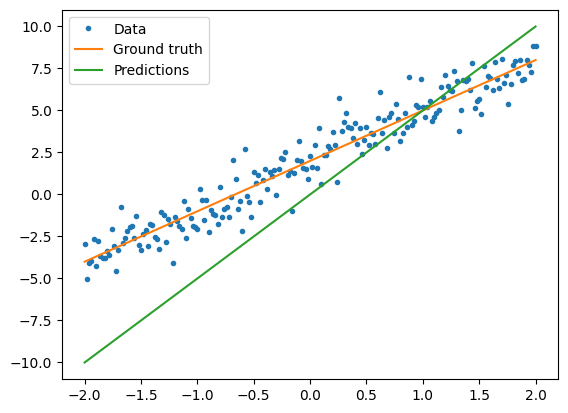

Current loss: 1222.306885


In [6]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model,x,y).numpy())

In [7]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(model,x,y)
  print([model.w, model.b])
  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])
  print(dw,db)
  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

In [8]:
# Collect the history of W-values and b-values to plot later
w = []
b = []
epochs = range(10)

# Define a training loop
def report(model, loss):
  return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"

def training_loop(model, x, y):
  vect_loss=[]
  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.002)

    # Track this before I update
    w.append(model.w.numpy())
    b.append(model.b.numpy())
    current_loss =loss(model,x,y)
    vect_loss.append(current_loss)
    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))
  return vect_loss

Starting:
     W = 5.00, b = 0.00, loss=1222.30688
[<tf.Variable 'w:0' shape=() dtype=float32, numpy=5.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>]
tf.Tensor(534.0683, shape=(), dtype=float32) tf.Tensor(-409.10654, shape=(), dtype=float32)
Epoch  0:
     W = 3.93, b = 0.82, loss=538.80621
[<tf.Variable 'w:0' shape=() dtype=float32, numpy=3.9318633>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.8182131>]
tf.Tensor(244.94504, shape=(), dtype=float32) tf.Tensor(-244.6457, shape=(), dtype=float32)
Epoch  1:
     W = 3.44, b = 1.31, loss=355.64807
[<tf.Variable 'w:0' shape=() dtype=float32, numpy=3.4419732>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.3075045>]
tf.Tensor(112.34158, shape=(), dtype=float32) tf.Tensor(-146.29811, shape=(), dtype=float32)
Epoch  2:
     W = 3.22, b = 1.60, loss=303.03668
[<tf.Variable 'w:0' shape=() dtype=float32, numpy=3.21729>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.6001008>]
tf.Tensor(51.524

Text(0, 0.5, 'Loss')

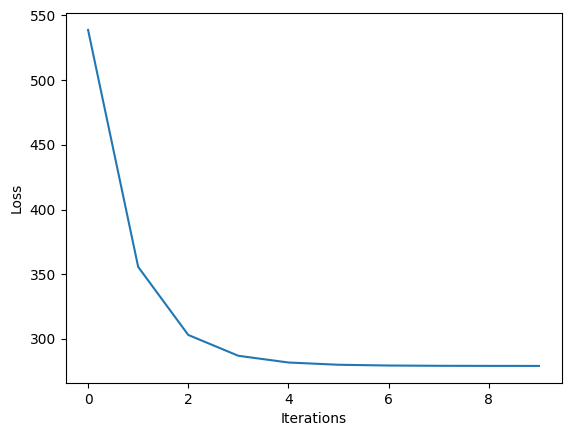

In [9]:
current_loss = loss(model,x,y)

print(f"Starting:")
print("    ", report(model, current_loss))

vect_loss=training_loop(model, x, y)

plt.plot(range(len(vect_loss)),vect_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')

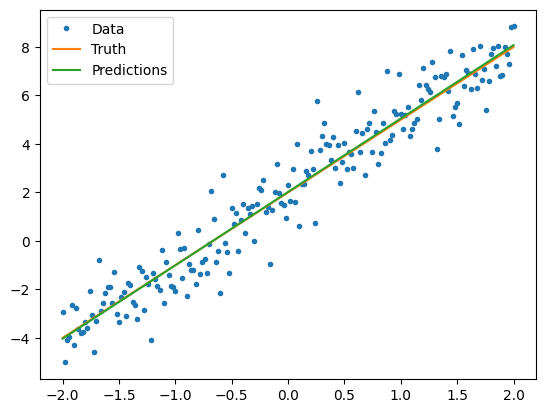

Current loss: 279.107758


In [10]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model,x, y).numpy())

In [11]:
class LinearModel(tf.Module):
  def __init__(self,w,b,**kwargs):
    super().__init__(**kwargs)
    self.w = tf.Variable(w,name='lin_param')
    self.b = tf.Variable(b,name='ind_param')
    #print('w',self.w)
    #print('b',self.b)
  def __call__(self, x): #x must be a tensor
    # w and b can be (n,m) shaped tensors
    s=np.array(self.w.shape)
    l=len(s)
    ax1=s[0]
    if l==1 and ax1==1:
       res= self.w * x + self.b
    else:
      result=np.zeros((ax1,len(x.numpy())))
      for i in range(ax1):
           update=self.w[i]*x+self.b[i]
           update=update.numpy()
           result[i]=update
      res=tf.constant(result)
           #print(np.shape(res[i]), np.shape(w_numpy[i]*x), np.shape(b_numpy[i]*np.ones(len(x))))
    return tf.cast(res, tf.float32)


#defining the prior
#DEFINING THE PRIOR, LIKELIHOOD AND POSTERIOR

def logprior(w,b):
    lin_coef, ind_coef = w,b
    p_lin_coef=tfd.Normal(4.5,3)
    p_ind_coef=tfd.Normal(1.5,3)
    return p_ind_coef.log_prob(lin_coef)+p_ind_coef.log_prob(ind_coef)

def loglikelihood(w,b,x,target_y):  #the input argument Linearmodel is just (LinearModel([params]))
    model=LinearModel(w,b)
    predicted_y=model(x)
    s=np.array(model.w.shape)
    l=len(s)
    ax1=s[0]
    sigma=1
    prob_y=tfd.Normal(target_y,sigma)
    if ax1==1:
      L=tf.math.reduce_sum(prob_y.log_prob(predicted_y))
    else:
      L=tf.math.reduce_sum(prob_y.log_prob(predicted_y),axis=1)
    return L

    '''for i in range(len(target_y)):
      prob_y=tfd.Normal(target_y[i],sigma)
      a=a+prob_y.log_prob(predicted_y[i])'''


def logposterior(w,b,x,target_y): #the input argument Linearmodel is just (LinearModel([params]))
  return logprior(w,b)+loglikelihood(w,b,x,target_y)

def posterior(LinearModel,x,target_y): #the input argument Linearmodel is just (LinearModel([params])). We need this function for the KL divergence.
  return tf.exp(logposterior(LinearModel,x,target_y))

def loss(LinearModel,x,target_y):
  return -logposterior(LinearModel,x,target_y)



In [12]:
param1=tf.constant([5.09, 5.10, 5.85])
param2=tf.constant([0.98, 1.05, 1.07])
model=LinearModel(param1,param2)
z=model(x)

ll=loglikelihood(param1,param2,x,y)
print('ll',ll)

lll=logposterior(param1,param2,x,y)
print(lll)

ll tf.Tensor([ -962.45996  -953.7013  -1446.7614 ], shape=(3,), dtype=float32)
tf.Tensor([ -967.2261   -958.46765 -1451.858  ], shape=(3,), dtype=float32)


In [13]:
def SVI(x,target_y,optimizer,start, n_vi, init_scales=1e-3, num_steps=500, seed=2):
        tf.random.set_seed(seed)
        start = tf.squeeze(start)
        scale = (
            np.ones(len(start)).astype(np.float32) * init_scales
            if np.size(init_scales) == 1
            else init_scales
        )
        q_z = tfd.MultivariateNormalTriL( #this is the surrogate posterior, which we choose to be a multivariable gaussian
            loc=tf.Variable(start), #initially, we set the mean to be the start tensor, which is the best MAP
            scale_tril=tfp.util.TransformedVariable(
                np.diag(scale),
                tfp.bijectors.FillScaleTriL(diag_bijector=tfp.bijectors.Exp(), diag_shift=1e-6),
                name="stddev",
            ),
        )
        #callable=lambda params: logposterior(params[:,0],params[:,1],x,target_y)
        losses = tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn= lambda params: 1*logposterior(params[:,0],params[:,1],x,target_y),
            surrogate_posterior=q_z,
            sample_size=n_vi,
            optimizer=optimizer,
            num_steps=num_steps,
        )


        return q_z, losses


In [14]:
start=[5.09, 0.98]
tf.config.run_functions_eagerly(True)
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 250, 4e-6, 200)
optimizer = tf.keras.optimizers.legacy.Adam(schedule_fn)
q_z, losses = SVI(x,y,optimizer=optimizer,start=start, n_vi=1, num_steps=500, seed=2)

tf.Tensor([5.0880985 0.9819896], shape=(2,), dtype=float32)
tf.Tensor([0.0010019  0.00100686], shape=(2,), dtype=float32)


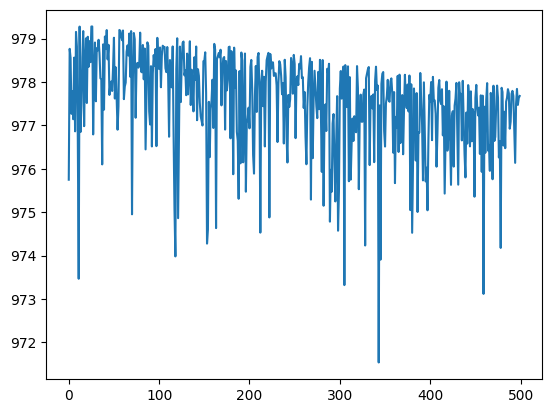

In [15]:
print(q_z.mean())
print(q_z.stddev())
plt.plot(losses)

In [16]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import (
    distributions as tfd,
    bijectors as tfb,
    experimental as tfe,
)
from tqdm.auto import trange, tqdm

def HMC(
            x,
            target_y,
            q_z,
            init_eps=0.3,
            init_l=3,
            n_hmc=50,
            num_burnin_steps=250,
            num_results=750,
            max_leapfrog_steps=30,
            seed=3,
    ):
        def tqdm_progress_bar_fn(num_steps):
            return iter(tqdm(range(num_steps), desc="", leave=True))

        tf.random.set_seed(seed)
        mc_start = q_z.sample(n_hmc)
        cov_estimate = q_z.covariance()

        momentum_distribution = (
            tfe.distributions.MultivariateNormalPrecisionFactorLinearOperator(
                precision_factor=tf.linalg.LinearOperatorLowerTriangular(
                    tf.linalg.cholesky(cov_estimate),
                ),
                precision=tf.linalg.LinearOperatorFullMatrix(cov_estimate),
            )
        )

        @tf.function
        def run_chain():
            num_adaptation_steps = int(num_burnin_steps * 0.8)
            start = tf.identity(mc_start)
            callable=lambda params: logposterior(params[:,0],params[:,1],x,target_y)

            mc_kernel = tfe.mcmc.PreconditionedHamiltonianMonteCarlo(
                target_log_prob_fn=callable,
                momentum_distribution=momentum_distribution,
                step_size=init_eps,
                num_leapfrog_steps=init_l,
            )

            mc_kernel = tfe.mcmc.GradientBasedTrajectoryLengthAdaptation(
                mc_kernel,
                num_adaptation_steps=num_adaptation_steps,
                max_leapfrog_steps=max_leapfrog_steps,
            )
            mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
                inner_kernel=mc_kernel, num_adaptation_steps=num_adaptation_steps
            )

            pbar = tfe.mcmc.ProgressBarReducer(
                num_results + num_burnin_steps - 1, progress_bar_fn=tqdm_progress_bar_fn
            )
            mc_kernel = tfe.mcmc.WithReductions(mc_kernel, pbar)

            return tfp.mcmc.sample_chain(
                num_results=num_results,
                num_burnin_steps=num_burnin_steps,
                current_state=start,
                kernel=mc_kernel,
                seed=seed,
            )

        return run_chain()

In [ ]:
#Sampling from SVI
samples, sample_stats = HMC(x,y,q_z=q_z, n_hmc=8, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=200, num_results=750)

  0%|          | 0/949 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [ ]:
!pip install corner
from corner import corner

In [ ]:
samples_n=samples.numpy()
print(np.shape(samples_n))
n=750*8
s_R=samples_n.reshape((n,2))
print(s_R)
figure=corner(s_R, show_titles=True,labels=['Slope', 'Intercept'])
plt.figtext(0.95, 0.95, 'True slope=5, True interceipt=1', color='black', weight='bold', size='large')
plt.show()

In [ ]:
colors = ['#1f0a1d','limegreen','seagreen','navy','darkkhaki']
fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(1, 2, width_ratios=[1, .4], height_ratios=[1])
ax1 = plt.subplot(gs[0, 0],)

for i in range(4):
 ax1.plot(samples_n[:,i,0], colors[i], label = f'{i}', alpha = 0.6)
 plt.title('Slope trace sampling from SVI')
#  plt.legend(title = 'Chains', loc = 'center left', bbox_to_anchor=(1.1, 0.5))

ax1.grid(True)

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
for i in range(4):
  prob, bins = np.histogram(samples_n[:,i,0], density = True, bins = 40)
  (mu, sigma) = norm.fit(samples_n[:,i,0])

  y = norm.pdf(bins, mu, sigma)
  ax2.plot(y, bins, colors[i], linewidth=2, alpha = 0.8)

ax2.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)
plt.tick_params(axis='y', labelsize=0)
plt.gca().axes.get_yaxis().set_visible(True)
plt.tight_layout()
plt.show()

In [ ]:
colors = ['#1f0a1d','limegreen','seagreen','navy','darkkhaki']
fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(1, 2, width_ratios=[1, .4], height_ratios=[1])
ax1 = plt.subplot(gs[0, 0],)

for i in range(4):
 ax1.plot(samples_n[:,i,1], colors[i], label = f'{i}', alpha = 0.6)
 plt.title('Interceipt trace sampling from SVI')
#  plt.legend(title = 'Chains', loc = 'center left', bbox_to_anchor=(1.1, 0.5))

ax1.grid(True)

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
for i in range(4):
  prob, bins = np.histogram(samples_n[:,i,1], density = True, bins = 40)
  (mu, sigma) = norm.fit(samples_n[:,i,1])

  y = norm.pdf(bins, mu, sigma)
  ax2.plot(y, bins, colors[i], linewidth=2, alpha = 0.8)

ax2.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)
plt.tick_params(axis='y', labelsize=0)
plt.gca().axes.get_yaxis().set_visible(True)
plt.tight_layout()
plt.show()

In [ ]:
#Sampling from best MAP
start=[5.09, 0.98]
init_scales=1e-6
tf.random.set_seed(2)
start = tf.squeeze(start)
scale = (
          np.ones(len(start)).astype(np.float32) * init_scales
          if np.size(init_scales) == 1
          else init_scales
        )
q_z1 = tfd.MultivariateNormalTriL( #this is the surrogate posterior, which we choose to be a multivariable gaussian
      loc=tf.Variable(start), #initially, we set the mean to be the start tensor, which is the best MAP
      scale_tril=tfp.util.TransformedVariable(
       np.diag(scale),
      tfp.bijectors.FillScaleTriL(diag_bijector=tfp.bijectors.Exp(), diag_shift=1e-6),
      name="stddev",
            ),
        )

In [ ]:
x = tf.linspace(-2,2, NUM_DATA)
x = tf.cast(x, tf.float32)
y= f(x) + noise
y = tf.cast(y, tf.float32)

In [ ]:
samples2, sample_stats = HMC(x,y,q_z=q_z1, n_hmc=8, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

In [ ]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
print(Rhat)

In [ ]:
samples_2n=samples2.numpy()
print(np.shape(samples_2n))
shape_samples=8*750
s_R2=samples_2n.reshape((shape_samples,2))
figure=corner(s_R2, show_titles=True,labels=['Slope', 'Intercept'])
plt.figtext(0.95, 0.95, 'True slope=5, True interceipt=1', color='black', weight='bold', size='large')
plt.show()

In [ ]:
colors = ['#1f0a1d','limegreen','seagreen','navy','darkkhaki']
fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(1, 2, width_ratios=[1, .4], height_ratios=[1])
ax1 = plt.subplot(gs[0, 0],)

for i in range(4):
 ax1.plot(samples_2n[:,i,0], colors[i], label = f'{i}', alpha = 0.6)
 plt.title('Slope trace sampling from SVI')
#  plt.legend(title = 'Chains', loc = 'center left', bbox_to_anchor=(1.1, 0.5))

ax1.grid(True)

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
for i in range(4):
  prob, bins = np.histogram(samples_2n[:,i,0], density = True, bins = 40)
  (mu, sigma) = norm.fit(samples_2n[:,i,0])

  y = norm.pdf(bins, mu, sigma)
  ax2.plot(y, bins, colors[i], linewidth=2, alpha = 0.8)

ax2.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)
plt.tick_params(axis='y', labelsize=0)
plt.gca().axes.get_yaxis().set_visible(True)
plt.tight_layout()
plt.show()

In [ ]:
colors = ['#1f0a1d','limegreen','seagreen','navy','darkkhaki']
fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(1, 2, width_ratios=[1, .4], height_ratios=[1])
ax1 = plt.subplot(gs[0, 0],)

for i in range(4):
 ax1.plot(samples_n[:,i,1], colors[i], label = f'{i}', alpha = 0.6)
 plt.title('Intercepit trace sampling from MAP result')
#  plt.legend(title = 'Chains', loc = 'center left', bbox_to_anchor=(1.1, 0.5))

ax1.grid(True)

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
for i in range(4):
  prob, bins = np.histogram(samples_n[:,i,1], density = True, bins = 40)
  (mu, sigma) = norm.fit(samples_n[:,i,1])

  y = norm.pdf(bins, mu, sigma)
  ax2.plot(y, bins, colors[i], linewidth=2, alpha = 0.8)

ax2.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)
plt.tick_params(axis='y', labelsize=0)
plt.gca().axes.get_yaxis().set_visible(True)
plt.tight_layout()
plt.show()